In [424]:
import numpy as np
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

# Feature selection modules
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from scipy import stats

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from catboost import CatBoostClassifier, Pool, cv

from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
import category_encoders as ce # Encoding modules
# Hyperparameter tuning modules
from sklearn.model_selection import GridSearchCV

# Data sampling modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Model saving module
import pickle


### 0. Statement of business problems:
#### It is necessary to implement a set of measures to detect fraud in the banking sector.
#### It is necessary to detect situations when a fraudster makes payments on a card without the knowledge of the owner. One of the most effective tools for solving the problem of identifying fraudulent banking transactions is machine learning. Note that the sample is often unbalanced and cannot be so; fraudulent transactions of the total number of transactions fluctuate around 2%.

### Metric selection
In our case, having an unbalanced sample, Accuracy is not applicable.
If it is important to minimize false negatives, then the Recall metric will be more appropriate. Recall measures the proportion of all true positive cases that the model classified correctly.
Thus, the higher the Recall, the fewer false negatives the model has. This is especially important in cases where false negatives can have serious consequences
In such tasks that solve the problem of detecting high risk, the Recall metric is the most suitable; you can also focus on the complex metric F 1 score.

### 1. Getting to know the data and handling gaps

In [35]:
df = pd.read_csv('dataset.csv')
df.head(2)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,transaction_env,event_timestamp,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,fraud
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,X,12/29/2020 9:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,False
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,W,6/22/2021 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,False


### Description of symptoms

1.	account_age_days: Account age in days (numeric value).
2.	transaction_amt: Transaction amount (numeric value).
3.	transaction_adj_amt: Adjusted transaction amount (numeric value).
4.	historic_velocity: Historical transaction velocity (numeric value).
5.	ip_address: IP address (string value).
6.	user_agent: User agent information (string value).
7.	email_domain: Email domain (string value).
8.	phone_number: Phone number (string value).
9.	billing_city: Billing city (string value).
10.	billing_postal: Billing postal code (numeric value).
11.	billing_state: Billing state (string value).
12.	card_bin: Card BIN (numeric value).
13.	currency: Transaction currency (string value).
14.	signature_image: Signature image (string value).
15.	transaction_type: Transaction type (string value).
16.	transaction_env: Transaction environment (string value).
17.	event_timestamp: Event timestamp (string value).
18.	applicant_name: Applicant name (string value).
19.	billing_address: Billing address (string value).
20.	merchant_id: Merchant ID (string value).
21.	locale: Locale (string value).
22.	transaction_initiate: Transaction initiation (string value).
23.	days_since_last_logon: Days since last logon (numeric value).
24.	inital_amount: Initial amount (numeric value).
25.	fraud: Target variable indicating whether the transaction is fraudulent (binary value).

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  signature_image        149895 non-null  object 
 14  transaction_type       149884 non-nu

In [37]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
print(df['event_timestamp'].max())
print(df['event_timestamp'].min())

2021-10-25 14:27:00
2020-10-25 08:44:00


So we have a dataset with transaction data for a year, there is a target sign of fraud, we will try to determine it based on dependencies in the data. We will use the F1 score metric for assessing the quality of the model.

### 2. Preprocessing

In [38]:
df.duplicated().sum() #duplicate

0

In [39]:
df.isnull().sum() #data gaps

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
signature_image          105
transaction_type         116
transaction_env          123
event_timestamp          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
fraud                      0
dtype: int64

In [40]:
df.fraud.value_counts() #target variable distribution

False    141836
True       8164
Name: fraud, dtype: int64

Fraudulent transactions with data gaps of less than 2 percent of the data. We decide to remove them

In [41]:
#how many missing values ​​in the data where the transaction turned out to be fraudulent
df.loc[df['fraud'] == True].isnull().sum() 

account_age_days          6
transaction_amt           8
transaction_adj_amt      10
historic_velocity         3
ip_address                5
user_agent                7
email_domain              2
phone_number              5
billing_city              5
billing_postal            8
billing_state             7
card_bin                  8
currency                  7
signature_image           7
transaction_type          5
transaction_env           2
event_timestamp           6
applicant_name            4
billing_address          10
merchant_id               5
locale                    6
tranaction_initiate       4
days_since_last_logon     9
inital_amount            10
fraud                     0
dtype: int64

In [42]:
#how many transactions with empty values ​​for at least one attribute
df.loc[df['fraud'] == True].isnull().any(axis=1).sum()

149

Fraudulent transactions with data gaps of less than 2 percent of the data. We decide to remove them

In [43]:
df.dropna(axis=0, inplace=True)
df.fraud.value_counts()

False    139108
True       8015
Name: fraud, dtype: int64

__Before the omissions were removed, the percentage of fraudulent transactions was 5.75%; after the omissions were removed, the percentage changed slightly to 5.76%__

### 3. Exploratory data analysis and feature engineering

In [44]:
df.describe()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount
count,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000,147123.000000
mean,4645.914901,2521.396457,54.207466,4702.460173,50181.423720,41834.534560,49.861225,7996.496401
std,1153.744713,604.644319,10.068261,1188.161407,28388.654516,10081.175293,29.209468,4048.005539
min,1.000000,5.000000,1.000000,50.000000,503.000000,6040.000000,0.000000,1000.000000
25%,3824.000000,2103.000000,48.000000,3872.000000,25298.000000,35386.000000,24.000000,4484.000000
50%,4668.000000,2543.000000,55.000000,4730.000000,50072.000000,42086.000000,50.000000,7999.000000
75%,5476.000000,2951.000000,61.000000,5549.000000,74346.000000,47373.000000,75.000000,11494.500000
max,9119.000000,4999.000000,99.000000,9999.000000,99950.000000,67639.000000,100.000000,15000.000000


The data is quite logical, there are no negative values, completely acceptable figures for the life of the account, amounts in the account, etc.

Let's take a closer look at the account_age_days attribute

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


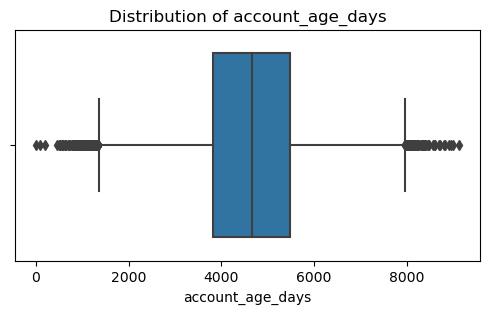

In [45]:
plt.figure(figsize=(6,3), facecolor='white')
sns.boxplot(df['account_age_days'])
plt.title('Distribution of account_age_days')
plt.show()

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


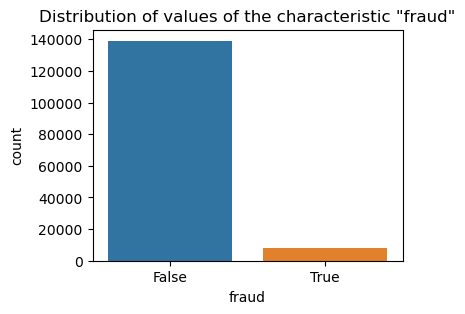

In [47]:
#Distribution of values ​​of the characteristic 'fraud'
plt.figure(figsize=(4,3), facecolor='white')
sns.countplot(df['fraud'])
plt.title('Distribution of values ​​of the characteristic "fraud"')
plt.show()

Let's look at the distribution of numerical characteristics

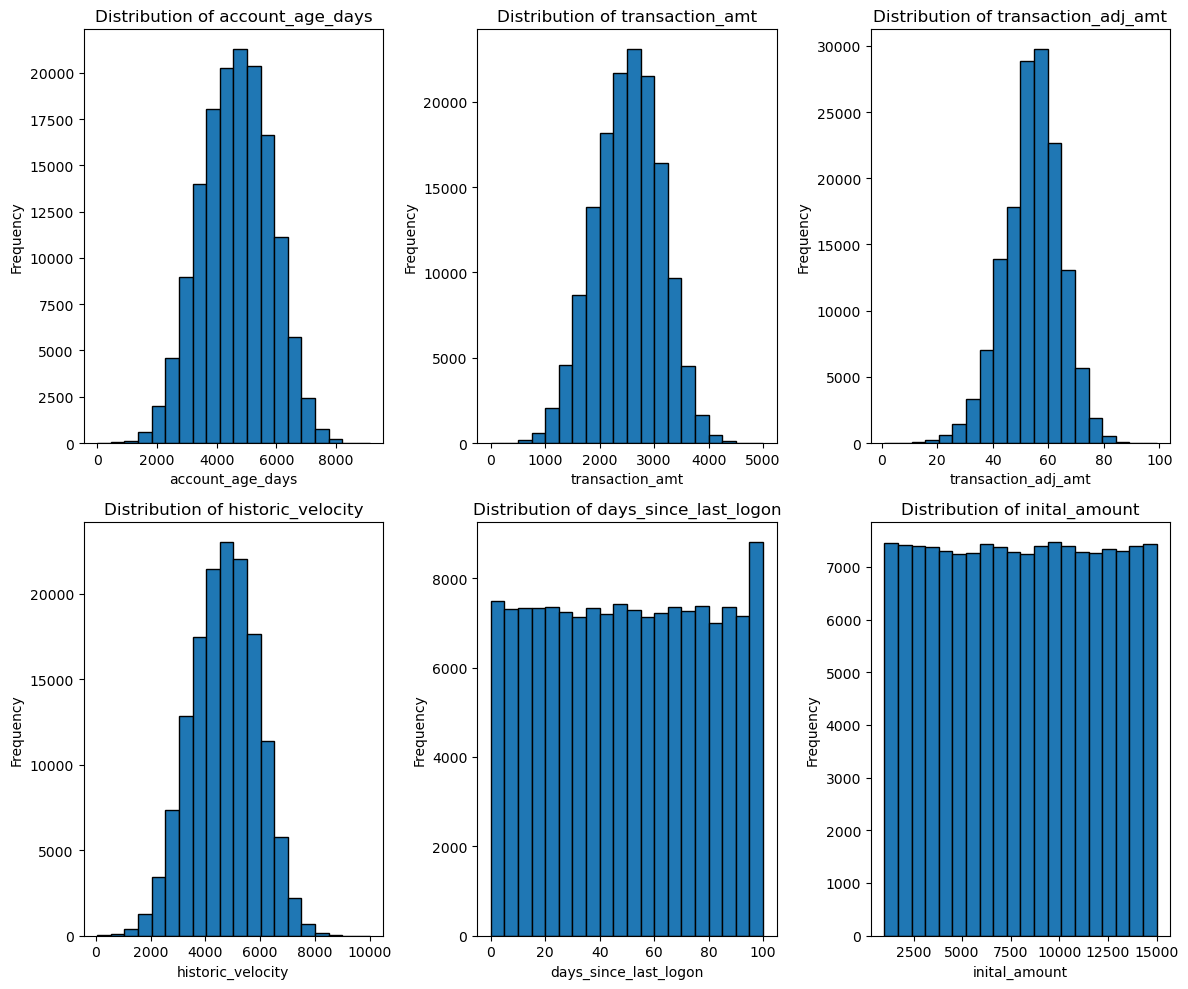

In [48]:
# Create a coordinate plane with 2x2 graphs
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10), facecolor='white')
# List of features for plotting
features = ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'days_since_last_logon', 'inital_amount']

# For each feature we build a histogram on the corresponding graph
for ax, feature in zip(axes.flatten(), features):
    ax.hist(df[feature], bins=20, edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Let's take a closer look at the days_since_last_logon sign

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


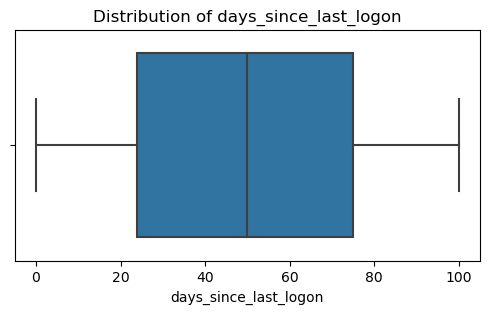

In [49]:
plt.figure(figsize=(6,3), facecolor='white')
sns.boxplot(df['days_since_last_logon'])
plt.title('Distribution of days_since_last_logon')
plt.show()

Visualization of numerical features represents the identification of normal distribution in them

In [ ]:
data = df.copy()

It would be interesting to see whether there is a dependence in fraudulent transactions on a new account or not, whether many days have passed since the last logging or not?

In [52]:
data['group_account_age_days'] = data['account_age_days'].apply(lambda x: 
    1 if x < 1000 
    else (2 if x < 2000 
          else (3 if x < 3000 
                else (4 if x < 4000 
                      else (5 if x < 5000 
                            else (6 if x < 6000 
                                  else (7 if x < 7000 
                                        else (8 if x < 8000 
                                              else (9 if x < 9000 
                                                    else 10)))))))))

data.groupby('group_account_age_days')['fraud'].value_counts(normalize=True) * 100

group_account_age_days  fraud
1                       False     97.826087
                        True       2.173913
2                       False     99.586093
                        True       0.413907
3                       False     99.392807
                        True       0.607193
4                       False     98.660197
                        True       1.339803
5                       False     94.871568
                        True       5.128432
6                       False     90.490383
                        True       9.509617
7                       False     92.029031
                        True       7.970969
8                       False     93.822739
                        True       6.177261
9                       False     95.555556
                        True       4.444444
10                      False    100.000000
Name: fraud, dtype: float64

In [53]:
data.groupby('group_account_age_days')['fraud'].value_counts()

group_account_age_days  fraud
1                       False       45
                        True         1
2                       False     1203
                        True         5
3                       False    10640
                        True        65
4                       False    31517
                        True       428
5                       False    42807
                        True      2314
6                       False    36131
                        True      3797
7                       False    14582
                        True      1263
8                       False     2096
                        True       138
9                       False       86
                        True         4
10                      False        1
Name: fraud, dtype: int64

In [54]:
data['group_days_since_last_logon'] = df['days_since_last_logon'].apply(lambda x: 
    1 if x < 10 
    else (2 if x < 20 
          else (3 if x < 30 
                else (4 if x < 40 
                      else (5 if x < 50 
                            else (6 if x < 60 
                                  else (7 if x < 70 
                                        else (8 if x < 80 
                                              else (9 if x < 90
                                                    else 10)))))))))


In [55]:
data.groupby('group_account_age_days')['fraud'].value_counts(normalize=True) * 100

group_account_age_days  fraud
1                       False     97.826087
                        True       2.173913
2                       False     99.586093
                        True       0.413907
3                       False     99.392807
                        True       0.607193
4                       False     98.660197
                        True       1.339803
5                       False     94.871568
                        True       5.128432
6                       False     90.490383
                        True       9.509617
7                       False     92.029031
                        True       7.970969
8                       False     93.822739
                        True       6.177261
9                       False     95.555556
                        True       4.444444
10                      False    100.000000
Name: fraud, dtype: float64

Signs based on the number of days since the last logging and the age of the account do not yet provide any interesting information, perhaps new signs will be useful to us

Look at what currency fraud occurs most often.

In [56]:
data[data['fraud']==True]['currency'].value_counts()

cad    5684
usd    1887
eur     444
Name: currency, dtype: int64

Let's see if we can identify any pattern depending on the date of the transaction


In [57]:
data['year'] = data['event_timestamp'].dt.year
data['month'] = data['event_timestamp'].dt.month
data['hour'] = data['event_timestamp'].dt.hour
data['day_of_week'] = data['event_timestamp'].dt.day_of_week

Text(0.5, 1.0, 'Distribution of fraud transactions by months')

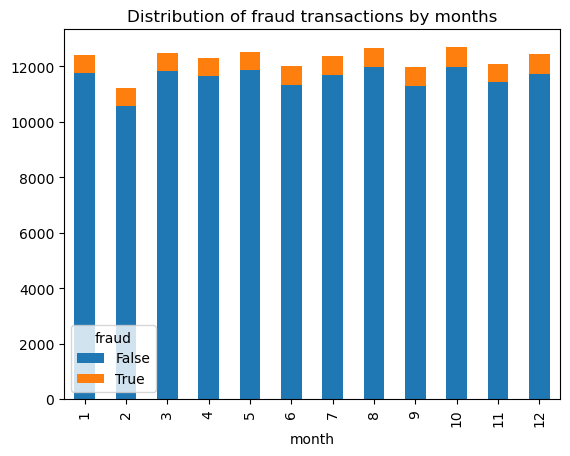

In [58]:
types = data.groupby("month")['fraud'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')
plt.title('Distribution of fraud transactions by months')

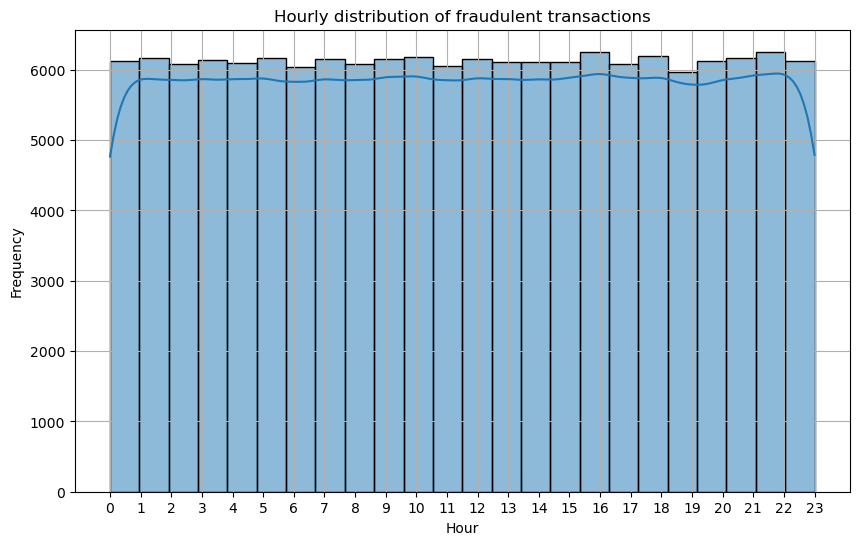

In [59]:
# Building a graph
plt.figure(figsize=(10, 6))
sns.histplot(data, x='hour', bins=24, edgecolor='black', kde=True)
plt.title('Hourly distribution of fraudulent transactions')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

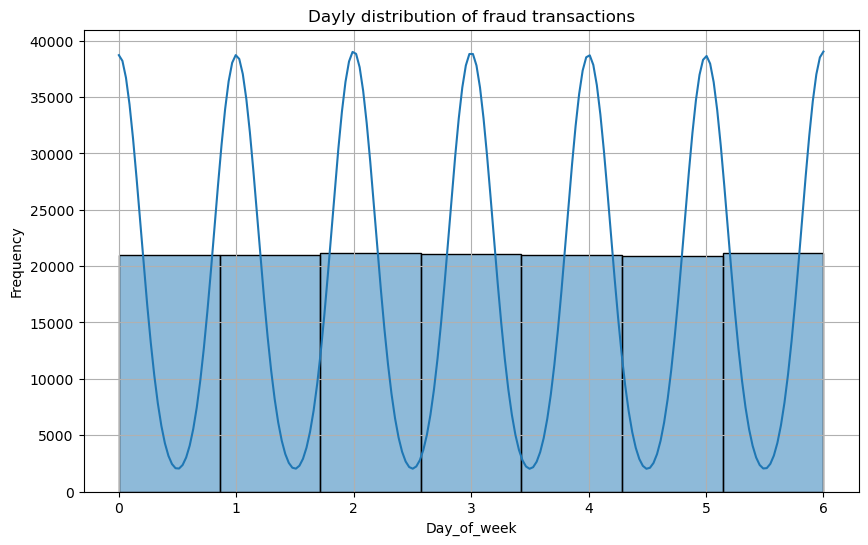

In [60]:
# Building a graph
plt.figure(figsize=(10, 6))
sns.histplot(data, x='day_of_week', bins=7, edgecolor='black', kde=True)
plt.title('Dayly distribution of fraud transactions')
plt.xlabel('Day_of_week')
plt.ylabel('Frequency')
plt.xticks(range(0, 7))
plt.grid(True)
plt.show()

__Based on the presented graphs, no dependencies on the time of the operation are detected. However, this is not visible to the eye, but perhaps it will be useful to us when building a model.__

Let's create a function to find out the country by IP.

In [64]:
import requests
def get_country(ip_address):
    # URL to send a request to the GeoIP API
    url = f"http://ip-api.com/json/{ip_address}"

    try:
        # Sending a GET request to the GeoIP API
        response = requests.get(url)
        df = response.json()

        # Extracting country and city information from a response
        country = df['country']
        

        return country

    except Exception as e:
        print("Error:", e)
        return None, None

# Example of using a function for an IP address
ip_address = "68.177.136.155"
country = get_country(ip_address)
print("Country:", country)

Country: United States


In [ ]:
data['ip_country'] = data['ip_address'].apply(get_country)

In [66]:
data['ip_country'].value_counts()

United States          57378
China                  14051
Japan                   7571
United Kingdom          6495
Germany                 5475
                       ...  
Cabo Verde                 1
Solomon Islands            1
Haiti                      1
Trinidad and Tobago        1
Bhutan                     1
Name: ip_country, Length: 154, dtype: int64

In [140]:
data['ip_country'].isnull().sum()

0

Great, we found the country by IP

In [68]:
data[data['fraud']==True]['ip_country'].value_counts() # Distribution of fraudulent transactions by country

United States                       3148
China                                760
Japan                                403
United Kingdom                       347
Germany                              313
                                    ... 
Democratic Republic of the Congo       1
Sri Lanka                              1
Oman                                   1
Palestinian Territory                  1
Senegal                                1
Name: ip_country, Length: 126, dtype: int64

In [67]:
ip_countries_list = list(data['ip_country'].unique()) #Let's look at the list of countries that we received from ip
print(ip_countries_list)

['Ivory Coast', 'China', 'United States', 'Japan', 'Australia', 'Italy', 'Belgium', 'Spain', 'Germany', 'United Kingdom', 'India', 'Brazil', 'Hong Kong', 'The Netherlands', 'Portugal', 'Canada', 'France', (None, None), 'Belarus', 'Russia', 'Mexico', 'Bulgaria', 'South Africa', 'Vietnam', 'Hungary', 'Benin', 'Poland', 'South Korea', 'Venezuela', 'Ireland', 'Argentina', 'Switzerland', 'Colombia', 'Sweden', 'Sudan', 'United Arab Emirates', 'Moldova', 'Zambia', 'Zimbabwe', 'Morocco', 'Czechia', 'Finland', 'Iran', 'Singapore', 'Denmark', 'Egypt', 'Ukraine', 'Philippines', 'Saudi Arabia', 'Taiwan', 'Nigeria', 'Chile', 'Kenya', 'Palestine', 'New Zealand', 'Kuwait', 'Belize', 'Norway', 'Algeria', 'Romania', 'Tunisia', 'Türkiye', 'Pakistan', 'Georgia', 'Thailand', 'Malaysia', 'Seychelles', 'Indonesia', 'Mauritius', 'Ecuador', 'Tanzania', 'Puerto Rico', 'Austria', 'Uganda', 'Greece', 'Estonia', 'Serbia', 'Slovakia', 'Malawi', 'Peru', 'Slovenia', 'Israel', 'Nepal', 'Netherlands', 'Mozambique', 'D

In [80]:
# Create a DataFrame with data for each unique country and output transactions where fraud == True
fraud_transactions = data[data['fraud'] == True].groupby('ip_country').size().reset_index(name='fraud_count')

# Create a DataFrame with data for each unique country and the total number of transactions
total_transactions = data.groupby('ip_country').size().reset_index(name='total_count')

# Join both DataFrames by column 'ip_country'
result_df = pd.merge(fraud_transactions, total_transactions, on='ip_country', how='outer')

# Fill in missing values ​​with zeros (if there were no fraudulent transactions for some countries)
result_df.fillna(0, inplace=True)

result_df.sort_values(by='fraud_count', ascending=False, inplace=True)
result_df.head(10)

,ip_country,fraud_count,total_count
121,United States,3148.0,57378
22,China,760.0,14051
56,Japan,403.0,7571
120,United Kingdom,347.0,6495
37,Germany,313.0,5475
100,South Korea,210.0,3802
34,France,207.0,3449
0,"(None, None)",202.0,3735
15,Brazil,190.0,3601
53,Italy,142.0,2767


In [85]:
def get_region(ip_address):
    # URL to send a request to the GeoIP API
    url = f"http://ip-api.com/json/{ip_address}"

    try:
        # Sending a GET request to the GeoIP API
        response = requests.get(url)
        data = response.json()

        # Extracting state/region information from a response
        region = data.get('regionName', None)  # 'regionName' may contain state or region

        return region

    except Exception as e:
        print("Error:", e)
        return None

# Example of using a function for an IP address
ip_address = "68.177.136.155"
region = get_region(ip_address)
print("state (region):", region)

state (region): Florida


In [ ]:
data['ip_state'] = data['ip_address'].apply(get_region)

In [87]:
data['ip_state'].value_counts()

Ohio                2963
California          1759
England             1739
New York            1262
Tokyo               1204
                    ... 
Manisa                 1
Leningrad Oblast       1
Sulaymaniyah           1
Puebla                 1
Kerala                 1
Name: ip_state, Length: 820, dtype: int64

In [138]:
data['ip_state'].isnull().sum()

106285

There were problems with obtaining the region, there were too many gaps, in this form this sign will not be useful to us.

In [89]:
ip_state_list = list(data['ip_state'].unique())
print(ip_state_list)

['Abidjan', 'Guangdong', 'Pennsylvania', 'New Jersey', 'Kanagawa', 'Illinois', 'Ohio', 'Queensland', 'Piedmont', 'Tokyo', 'Lombardy', 'Fujian', 'Hawaii', 'Flanders', 'Canary Islands', 'Arizona', 'Massachusetts', 'North Rhine-Westphalia', 'Alaska', 'Virginia', 'England', 'Bihar', 'Parana', 'Shaanxi', 'Central and Western District', 'Beijing', 'Shanghai', 'Campania', 'Hyōgo', 'North Holland', 'Lisbon', 'New York', 'California', 'Ontario', 'South Carolina', 'Ibaraki', 'Hesse', 'Brittany', 'Lazio', 'Washington', 'Aichi', 'Florida', None, 'Centre-Val de Loire', 'Minsk City', 'North Carolina', 'District of Columbia', 'St.-Petersburg', 'Georgia', 'Anhui', 'Colorado', 'Baja California', 'Sofia-Capital', 'Gauteng', 'Sao Paulo', 'Alabama', 'Bắc Ninh Province', 'Minnesota', 'Littoral', 'Hanoi', 'Limburg', 'Louisiana', 'Leinster', 'Oregon', 'Qinghai', 'Lower Saxony', 'Buenos Aires', 'Goias', 'Santa Fe', 'Stockholm County', 'New South Wales', 'Occitanie', 'Texas', 'Galicia', 'Gyeongsangbuk-do', 'Si

__So, great, we have the billing_country attribute that contains data from the country of card registration (USA) and data from the country where the transaction was carried out, ip_country. We will make additional indications whether the country and state of registration matches the country and state of the transaction__

The country of registration is not clearly indicated, but let's check whether the cards are registered in the states or not.

In [95]:
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida",
    "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine",
    "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska",
    "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
    "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

data['billing_country'] = data['billing_state'].apply(lambda x: 'United States' if x in states else None)
data['billing_country'].value_counts()


United States    147123
Name: billing_country, dtype: int64

All transactions with billing addresses from the USA

In [142]:
data['country_match'] = data.apply(lambda row: 0 if row['billing_country'] == row['ip_country'] else 1, axis=1)
print(data['country_match'].value_counts()) #Discrepancies by country (1 does not match)

1    89745
0    57378
Name: country_match, dtype: int64


We will transfer those addresses that have already been scammed to the list to give weight and mark those who are scammers

In [98]:
black_list = data[data['fraud'] == True]['ip_address'].unique().tolist()
print('IP addresses from which there were fraudulent transactions', black_list)
print('lenth of black list', len(black_list))

IP addresses from which there were fraudulent transactions ['192.167.7.42', '110.81.226.130', '93.204.224.31', '96.100.129.207', '179.105.147.32', '148.92.230.219', '211.69.245.145', '26.80.84.59', '96.31.180.211', '143.15.243.175', '193.88.88.39', '140.52.241.167', '27.126.49.10', '159.110.253.5', '37.242.38.37', '22.129.224.214', '40.90.96.113', '118.37.219.182', '51.239.6.85', '148.178.40.84', '220.136.33.1', '67.58.19.50', '45.140.226.174', '52.63.210.87', '65.161.47.78', '183.33.79.188', '36.55.154.85', '64.221.56.85', '52.227.226.208', '153.180.139.1', '221.107.175.65', '88.122.168.62', '55.75.197.38', '54.11.135.65', '83.3.91.183', '23.93.243.124', '148.44.122.27', '62.49.193.64', '80.32.206.234', '47.102.83.63', '145.212.60.183', '99.145.193.142', '140.166.187.13', '204.24.138.62', '213.169.204.55', '167.242.121.168', '47.33.172.61', '84.112.92.70', '62.240.183.21', '146.158.100.46', '196.53.241.72', '68.110.173.67', '110.39.218.175', '88.9.170.217', '91.107.15.135', '181.130.1

In [107]:
# let's make a dictionary from the ip from which the fraudulent transaction occurred
black_list_ip = data[data['fraud']==True]['ip_address'].value_counts(ascending=False).to_dict()
# Create a new black_list attribute
data['black_list'] = data['ip_address'].map(lambda x: 2 if x in black_list_ip and black_list_ip[x] > 1 else (1 if x in black_list_ip and black_list_ip[x] == 1 else 0))


In [168]:
data['browser'] = 'other'

# Condition for searching for occurrences of words
data.loc[data['user_agent'].str.contains('Opera'), 'browser'] = 1
data.loc[data['user_agent'].str.contains('Mozilla'), 'browser'] = 0

data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,hour,day_of_week,ip_country,ip_state,billing_country_USA,billing_country,country_match,black_list,browser,locale_country
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,9,1,Ivory Coast,Abidjan,1,United States,1,0,1,New Zealand
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,18,1,China,Guangdong,1,United States,1,1,1,India
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,13,0,United States,Pennsylvania,1,United States,0,0,0,Maldives
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,7,3,United States,New Jersey,1,United States,0,0,0,Eritrea
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,6,5,Japan,Kanagawa,1,United States,1,0,0,Nepal


Let's pay attention to the locale attribute. It contains the country and language region code for the transaction. Let's try to create a new attribute with the transaction country.

In [145]:
# We found the two-letter designation of countries from external sources and compiled the list
country_codes_short = ['NZ', 'IN', 'MV', 'ER', 'NP', 'PE', 'CA', 'SE', 'TW', 'IN', 'IN', 'UZ', 'IN', 'PL', 'NL', 'IN', 'RU', 'BE', 'IT', 'NU', 'KE', 'ZA', 'AF', 'TW', 'ID', 'NG', 'CZ', 'NO', 'IN', 'ZA', 'MX', 'BA', 'ZA', 'LK', 'FO', 'PL', 'AZ', 'IN', 'US', 'UG', 'SN', 'DK', 'MG', 'ER', 'GB', 'AM', 'IE', 'MM', 'SK', 'IR', 'CD', 'DJ', 'MA', 'AW', 'IN', 'NZ', 'MY', 'IN', 'IN', 'KZ', 'GB', 'MN', 'GR', 'HU', 'IN', 'ZA', 'FR', 'BD', 'US', 'BE', 'SV', 'ZA', 'PH', 'IN', 'IN', 'RU', 'KG', 'PH', 'ZA', 'ET', 'ET', 'JP', 'UA', 'IN', 'AN', 'UA', 'TW', 'TJ', 'VN', 'ET', 'GB', 'ES', 'BG', 'KH', 'IT', 'ES', 'CA', 'ET', 'KE', 'FR', 'ES', 'LV', 'IN', 'FR', 'IN', 'GB', 'RW', 'LK', 'ZM', 'KE', 'ES', 'IS', 'IN', 'IN', 'GL', 'LT', 'TR', 'IT', 'CR', 'UA', 'CH', 'EE', 'GH', 'ET', 'IN', 'TR', 'DJ', 'IN', 'RO', 'MK', 'CA', 'RU', 'TW', 'CN', 'UY', 'RU', 'RU', 'PK', 'IN', 'ZA', 'PL', 'BY', 'HT', 'IN', 'PK', 'BE', 'EG', 'GE', 'FI', 'NO', 'SG', 'TZ', 'US', 'NP', 'FR', 'CN', 'ET', 'LU', 'IN', 'MT', 'HK', 'SI', 'IN', 'ER', 'NG', 'ZA', 'IN', 'TM', 'AT', 'FR', 'FI', 'DZ', 'IN', 'IN', 'PK', 'HR', 'NG', 'AL', 'IL', 'NG', 'RU', 'PE', 'HK', 'CW', 'MR', 'KR', 'ZA', 'IN', 'ZA', 'DE', 'US', 'IQ', 'AG', 'SN', 'LU', 'ET', 'DE', 'NL', 'NO', 'ZW', 'ML', 'IN', 'AD', 'CA', 'HK', 'BT', 'ME', 'PT', 'CY', 'ER', 'LA', 'MX', 'CH', 'LU', 'PS', 'RS', 'IQ', 'SO', 'OM', 'EC', 'BE', 'DE', 'US', 'ES', 'CY', 'IL', 'CA', 'DO', 'LI', 'PR', 'IT', 'BO', 'SG', 'PY', 'DJ', 'GB', 'AU', 'HN', 'AE', 'IE', 'SO', 'SS', 'TN', 'SD', 'AR', 'PE', 'YE', 'GT', 'PH', 'DK', 'ZA', 'SY', 'NZ', 'ES', 'AR', 'DZ', 'VE', 'CO', 'CL', 'JO', 'KW', 'TD', 'MA', 'BW', 'SA', 'LB', 'LY', 'EH']

For convenience, we will make a dictionary where the country is the key and its two-letter designation is the value.

In [148]:
import pycountry

# Create an empty dictionary to store data
country_dict = {}

# Iterate through each country designation from the list
for code in country_codes_short:
    # We are trying to get a country object by designation
    try:
        country = pycountry.countries.get(alpha_2=code)
        # If the object is found, add it to the dictionary: key - country name, value - designation
        if country:
            country_dict[country.name] = code
    except LookupError:
        pass

# Output the resulting dictionary
print(country_dict)

{'New Zealand': 'NZ', 'India': 'IN', 'Maldives': 'MV', 'Eritrea': 'ER', 'Nepal': 'NP', 'Peru': 'PE', 'Canada': 'CA', 'Sweden': 'SE', 'Taiwan, Province of China': 'TW', 'Uzbekistan': 'UZ', 'Poland': 'PL', 'Netherlands': 'NL', 'Russian Federation': 'RU', 'Belgium': 'BE', 'Italy': 'IT', 'Niue': 'NU', 'Kenya': 'KE', 'South Africa': 'ZA', 'Afghanistan': 'AF', 'Indonesia': 'ID', 'Nigeria': 'NG', 'Czechia': 'CZ', 'Norway': 'NO', 'Mexico': 'MX', 'Bosnia and Herzegovina': 'BA', 'Sri Lanka': 'LK', 'Faroe Islands': 'FO', 'Azerbaijan': 'AZ', 'United States': 'US', 'Uganda': 'UG', 'Senegal': 'SN', 'Denmark': 'DK', 'Madagascar': 'MG', 'United Kingdom': 'GB', 'Armenia': 'AM', 'Ireland': 'IE', 'Myanmar': 'MM', 'Slovakia': 'SK', 'Iran, Islamic Republic of': 'IR', 'Congo, The Democratic Republic of the': 'CD', 'Djibouti': 'DJ', 'Morocco': 'MA', 'Aruba': 'AW', 'Malaysia': 'MY', 'Kazakhstan': 'KZ', 'Mongolia': 'MN', 'Greece': 'GR', 'Hungary': 'HU', 'France': 'FR', 'Bangladesh': 'BD', 'El Salvador': 'SV', 

Now let’s apply the function and get a new attribute locale_country with the country from the locale attribute

In [155]:
data['locale_country'] = data['locale'].str.split('_').str[1]
reverse_country_dict = {v: k for k, v in country_dict.items()}
data['locale_country'] = data['locale_country'].map(reverse_country_dict)
data['locale_country'].value_counts()

India                        21582
South Africa                  8217
Russian Federation            4424
Ethiopia                      4103
Taiwan, Province of China     3389
                             ...  
Tunisia                         25
Western Sahara                  25
Sudan                           24
Oman                            22
Lebanon                         20
Name: locale_country, Length: 139, dtype: int64

### 4. Coding and Feature Selection

Let's look at the number of unique values in the features. We need this to determine the type of feature coding.

In [170]:
# Number of unique values analysis
for col in data.columns:
    display(f'Number of unique attribute values - {col}: {data[col].nunique()}')

'Number of unique attribute values - account_age_days: 6465'

'Number of unique attribute values - transaction_amt: 3687'

'Number of unique attribute values - transaction_adj_amt: 92'

'Number of unique attribute values - historic_velocity: 6745'

'Number of unique attribute values - ip_address: 13635'

'Number of unique attribute values - user_agent: 8796'

'Number of unique attribute values - email_domain: 7125'

'Number of unique attribute values - phone_number: 12170'

'Number of unique attribute values - billing_city: 9169'

'Number of unique attribute values - billing_postal: 11299'

'Number of unique attribute values - billing_state: 50'

'Number of unique attribute values - card_bin: 6480'

'Number of unique attribute values - currency: 3'

'Number of unique attribute values - signature_image: 26'

'Number of unique attribute values - transaction_type: 26'

'Number of unique attribute values - transaction_env: 26'

'Number of unique attribute values - event_timestamp: 128414'

'Number of unique attribute values - applicant_name: 96048'

'Number of unique attribute values - billing_address: 147117'

'Number of unique attribute values - merchant_id: 147114'

'Number of unique attribute values - locale: 293'

'Number of unique attribute values - tranaction_initiate: 26'

'Number of unique attribute values - days_since_last_logon: 101'

'Number of unique attribute values - inital_amount: 14001'

'Number of unique attribute values - fraud: 2'

'Number of unique attribute values - group_account_age_days: 10'

'Number of unique attribute values - group_days_since_last_logon: 10'

'Number of unique attribute values - year: 2'

'Number of unique attribute values - month: 12'

'Number of unique attribute values - hour: 24'

'Number of unique attribute values - day_of_week: 7'

'Number of unique attribute values - ip_country: 154'

'Number of unique attribute values - ip_state: 820'

'Number of unique attribute values - billing_country_USA: 1'

'Number of unique attribute values - billing_country: 1'

'Number of unique attribute values - country_match: 2'

'Number of unique attribute values - black_list: 3'

'Number of unique attribute values - browser: 2'

'Number of unique attribute values - locale_country: 139'

In [193]:
data.ip_country.nunique()

154

In [185]:

data['transaction_type'] = data['transaction_type'].astype('category')
data['signature_image'] = data['signature_image'].astype('category')
data['transaction_env'] = data['transaction_env'].astype('category')
data['tranaction_initiate'] = data['tranaction_initiate'].astype('category')
data['browser'] = data['browser'].astype('category')
data['currency'] = data['currency'].astype('category')
data['ip_country'] = data['ip_country'].astype('category')
data['billing_city'] = data['billing_city'].astype('category')
data['billing_state'] = data['billing_state'].astype('category')
data['locale_country'] = data['locale_country'].astype('category')

In [ ]:
data_tr = data.copy()

In [187]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147123 entries, 0 to 149999
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   account_age_days             147123 non-null  float64       
 1   transaction_amt              147123 non-null  float64       
 2   transaction_adj_amt          147123 non-null  float64       
 3   historic_velocity            147123 non-null  float64       
 4   ip_address                   147123 non-null  object        
 5   user_agent                   147123 non-null  object        
 6   email_domain                 147123 non-null  object        
 7   phone_number                 147123 non-null  object        
 8   billing_city                 147123 non-null  category      
 9   billing_postal               147123 non-null  float64       
 10  billing_state                147123 non-null  category      
 11  card_bin                  

In [188]:
data_tr['billing_country'] = data_tr['billing_country'].apply(lambda x: 1 if x=='United States' else 0)

In [189]:
data_tr['fraud'] = data_tr['fraud'].apply(lambda x: 1 if x==True else 0)

The principle of feature encoding:

1. For nominal features (if less than 15) - OneHotEncoding
2. For nominal features (if more than 15) - BinaryEncoding

In [232]:
categorial_features_less_15 = ['currency', 'browser',]
df1= pd.get_dummies(data_tr[categorial_features_less_15])
df_encoder = pd.concat([data_tr,df1], axis = 1)
df_encoder.drop(categorial_features_less_15, axis=1, inplace=True)
df_encoder.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,...,billing_country_USA,billing_country,country_match,black_list,locale_country,currency_cad,currency_eur,currency_usd,browser_0,browser_1
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,...,1,1,1,0,New Zealand,1,0,0,0,1
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,...,1,1,1,1,India,1,0,0,0,1
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,...,1,1,0,0,Maldives,1,0,0,1,0
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,...,1,1,0,0,Eritrea,0,0,1,1,0
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,...,1,1,1,0,Nepal,1,0,0,1,0


In [233]:
# Encoding nominal features 15 and more nununique
nom_features_15_more = ['billing_city', 'billing_state', 'signature_image', 'transaction_type', 'transaction_env', 'tranaction_initiate', 'ip_country', 'locale_country']
encoder = ce.BinaryEncoder(cols=nom_features_15_more)
type_bin = encoder.fit_transform(df_encoder[nom_features_15_more])
df_encoder = pd.concat([df_encoder, type_bin], axis=1)
df_encoder.drop(nom_features_15_more, axis=1, inplace=True)
df_encoder.head(2)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_postal,card_bin,...,ip_country_6,ip_country_7,locale_country_0,locale_country_1,locale_country_2,locale_country_3,locale_country_4,locale_country_5,locale_country_6,locale_country_7
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,96336.0,40771.0,...,0,1,0,0,0,0,0,0,0,1
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,78083.0,24480.0,...,1,0,0,0,0,0,0,0,1,0


In [234]:
df_encoder.drop(['user_agent', 'ip_address', 'email_domain', 'phone_number', 'billing_postal', 'card_bin', 'event_timestamp', 'applicant_name', 'billing_address', 'merchant_id', 'locale', 'ip_state'], axis=1, inplace=True)
df_encoder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147123 entries, 0 to 149999
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   account_age_days             147123 non-null  float64
 1   transaction_amt              147123 non-null  float64
 2   transaction_adj_amt          147123 non-null  float64
 3   historic_velocity            147123 non-null  float64
 4   days_since_last_logon        147123 non-null  float64
 5   inital_amount                147123 non-null  float64
 6   fraud                        147123 non-null  int64  
 7   group_account_age_days       147123 non-null  int64  
 8   group_days_since_last_logon  147123 non-null  int64  
 9   year                         147123 non-null  int64  
 10  month                        147123 non-null  int64  
 11  hour                         147123 non-null  int64  
 12  day_of_week                  147123 non-null  int64  
 13 

Let's look at the correlation matrix.

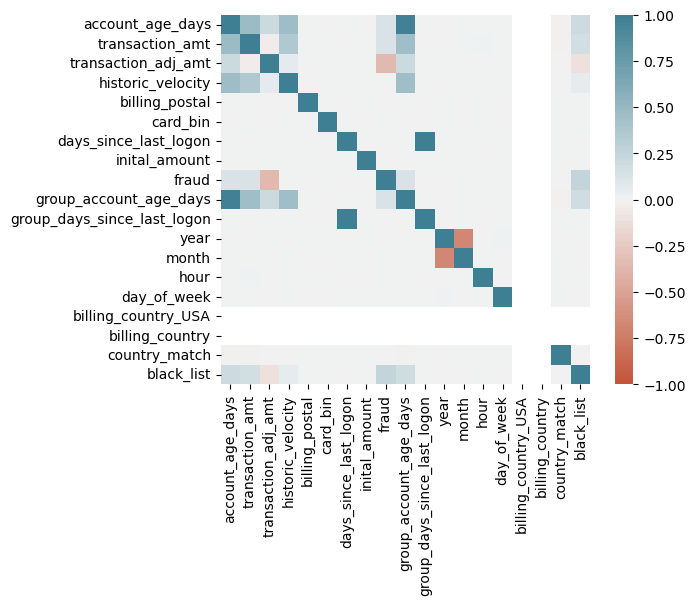

In [214]:
corr = data_tr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

We formed the group_days_since_last_logon and group_account_age_days characteristics based on the existing indicators of the number of days the account has existed and the last visit; as expected, they are highly correlated. Let's try to remove it for further work.

In [235]:
df_processed = df_encoder.drop(['group_days_since_last_logon', 'group_account_age_days'], axis=1) #data with indications of number of days

In [236]:
df_processed_1 = df_encoder.drop(['days_since_last_logon', 'account_age_days'], axis=1) #data with groups (new features based on the account’s lifespan and last logging)

#### Сonclusions

So, after conducting an intelligence analysis, it should be assumed that the most important information for identifying fraudulent transactions is stored in the location and IP addresses, and the signs account_age_days days_since_last_logon may also be useful. Attempts to find out any patterns from the timing of transactions (for example, to confirm the hypothesis that more fraud occurs at night) failed. Most likely, just like the development of the industry, the development of fraud in the industry is also taking place. It is necessary to pay attention to the fact that all cards are registered in the USA, but the location of transactions is distributed in many countries. So, we processed the data and added new features. Now let's see how machine learning algorithms cope with the task and identify patterns in the data.

## 5. ML

In [344]:
# Getting model evalution statistics
model_evalution_df = pd.DataFrame(columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])

def add_model_evalution_stat(model_name, model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, model_evalution_df):
    """Function for adding model evalution statistics to DataFrame

    Args:
        model_name (str): Model name
        model (object): Object of fitted model
        X_train (DataFrame): Train dataset
        X_test (DataFrame): Test dataset
        y_train (DataFrame): Train labels
        y_test (DataFrame): Test labels
        y_train_pred (DataFrame): Predicted train labels
        y_test_pred (DataFrame): Predicted test labels
        model_evalution_df (DataFrame): DataFrame with evalution statistics

    Returns:
        DataFrame: DataFrame with added statistics
    """
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred, average='weighted')
    precision = metrics.precision_score(y_test, y_test_pred)
    recall = metrics.recall_score(y_test, y_test_pred)
    model_evalutions_stats = [model_name, train_score, test_score, accuracy, f1_score, precision, recall]
    model_evalution_dict = {model_evalution_df.columns[i]:model_evalutions_stats[i] for i in range(len(model_evalutions_stats))}
    model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)
    return model_evalution_df

In [217]:
X = df_processed.drop(['fraud'], axis=1)
y = df_processed['fraud']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.30)

In [218]:
print(X_test.shape)
print(X_train.shape)

(44137, 75)
(102986, 75)


### Baseline

__Let's work on creating a baseline__

Let's take a not so simple model and experiment with a random forest

In [224]:
model_rf = ensemble.RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=10,
    min_samples_split=2,
    random_state=13
)

model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
print('Train recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Train f1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_rf.predict(X_test)
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print()
print('Test f1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train recall: 0.35
Train f1: 0.52
Test recall: 0.27

Test f1: 0.43


Let's make another basic model using df_processed_1 data

Let us recall that at the stage of reconnaissance analysis we identified two correlated features and the df_processed_1 data contains one of them - days_since_last_logon, the df_processed data contains the other - group_days_since_last_logon

In [237]:
X_1 = df_processed_1.drop(['fraud'], axis=1)
y_1 = df_processed_1['fraud']
 
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, stratify=y, random_state = 42, test_size = 0.30)

In [239]:
model_rf_1 = ensemble.RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=10,
    min_samples_split=2,
    random_state=13
)

model_rf_1.fit(X_train_1, y_train_1)
y_train_pred_1 = model_rf_1.predict(X_train_1)
print('Train recall: {:.2f}'.format(metrics.recall_score(y_train_1, y_train_pred_1)))
print('Train f1: {:.2f}'.format(metrics.f1_score(y_train_1, y_train_pred_1)))
y_test_pred_1 = model_rf_1.predict(X_test_1)
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test_1, y_test_pred_1)))
print()
print('Test f1: {:.2f}'.format(metrics.f1_score(y_test_1, y_test_pred_1)))

Train recall: 0.40
Train f1: 0.57
Test recall: 0.34

Test f1: 0.50


#### Select the most suitable features

In [245]:
# using SelectKBest we will select the most suitable features
best_f = SelectKBest(k='all')
best_f.fit(X_train, y_train)
X_train_fs = best_f.transform(X_train)
X_test_fs = best_f.transform(X_test)

# display selected features and their scores
selected_features = best_f.get_support(indices=True)
feature_scores = best_f.scores_[selected_features]
for i, (feature, score) in enumerate(zip(X_train.columns[selected_features], feature_scores), 1):
    print(f"{i}. Feature: {feature}, Score: {score}")

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


1. Feature: account_age_days, Score: 1815.3937850020484
2. Feature: transaction_amt, Score: 1580.3951123068073
3. Feature: transaction_adj_amt, Score: 15841.400495512637
4. Feature: historic_velocity, Score: 0.11054434179965776
5. Feature: days_since_last_logon, Score: 0.011331690301879013
6. Feature: inital_amount, Score: 0.07478969604828632
7. Feature: year, Score: 1.68893844353431
8. Feature: month, Score: 6.420333424866
9. Feature: hour, Score: 0.46716840820262706
10. Feature: day_of_week, Score: 2.062373288970358
11. Feature: billing_country_USA, Score: nan
12. Feature: billing_country, Score: nan
13. Feature: country_match, Score: 0.2409949941203818
14. Feature: black_list, Score: 7139.093656679107
15. Feature: currency_cad, Score: 73.15444956692386
16. Feature: currency_eur, Score: 124.0974935911433
17. Feature: currency_usd, Score: 18.91011953887548
18. Feature: browser_0, Score: 0.012919131174316766
19. Feature: browser_1, Score: 0.012919131124584749
20. Feature: billing_city_

Using SelectKBest, we will select 25 features that are best for predicting the target variable. We implement selection using a training sample using the chi2 parameter

We indicate the characteristics that are included in the selected list

In [248]:
from sklearn.feature_selection import SelectKBest, chi2

# Create a SelectKBest object with score_func=chi2 and k=25
best_features_selector = SelectKBest(score_func=chi2, k=25)

# We train SelectKBest using training data
X_train_selected = best_features_selector.fit_transform(X_train, y_train)

# Displaying selected features
selected_feature_indices = best_features_selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
print(selected_features)

Index(['account_age_days', 'transaction_amt', 'transaction_adj_amt',
       'historic_velocity', 'inital_amount', 'month', 'day_of_week',
       'black_list', 'currency_cad', 'currency_eur', 'currency_usd',
       'billing_city_1', 'billing_state_0', 'signature_image_0',
       'signature_image_1', 'signature_image_2', 'signature_image_4',
       'transaction_type_1', 'transaction_type_2', 'transaction_type_3',
       'transaction_env_0', 'transaction_env_1', 'transaction_env_2',
       'transaction_env_3', 'transaction_env_4'],
      dtype='object')


In [254]:
X_train = X_train_selected
X_test = X_test[['account_age_days', 'transaction_amt', 'transaction_adj_amt',
       'historic_velocity', 'inital_amount', 'month', 'day_of_week',
       'black_list', 'currency_cad', 'currency_eur', 'currency_usd',
       'billing_city_1', 'billing_state_0', 'signature_image_0',
       'signature_image_1', 'signature_image_2', 'signature_image_4',
       'transaction_type_1', 'transaction_type_2', 'transaction_type_3',
       'transaction_env_0', 'transaction_env_1', 'transaction_env_2',
       'transaction_env_3', 'transaction_env_4']]

In [255]:
# normalize the data using minmaxscaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


We have selected the features, let's see how random forest works on them

We will fill out the table for clarity

#### LogisticRegression

In [345]:
# Model with random under sampled data
model_name = 'LogisticRegression / Imbalanced data'
lr = linear_model.LogisticRegression(random_state=42, max_iter=1000)

lr = lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test, y_test_pred)}')
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, lr, X_train_scaled, X_test_scaled, y_train, y_test, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     41732
           1       0.81      0.55      0.65      2405

    accuracy                           0.97     44137
   macro avg       0.89      0.77      0.82     44137
weighted avg       0.97      0.97      0.97     44137



/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441


#### RandomForest

In [346]:
model_name2 = 'Baseline - RandomForestClassifier / Imbalanced data'

In [322]:
random_forest_base = ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    criterion='gini',
    min_samples_leaf=20,
    random_state=42
)
random_forest_base.fit(X_train_scaled, y_train)
y_train_pred_rf = random_forest_base.predict(X_train_scaled)
y_test_pred_rf = random_forest_base.predict(X_test_scaled)
# Calculation of the RMSLE metric on training and validation sets
print('Recall train', round(np.sqrt(metrics.recall_score(y_train, y_train_pred_rf)), 2))
print('Recall test', round(np.sqrt(metrics.recall_score(y_test, y_test_pred_rf)), 2))

Recall train 0.74
Recall test 0.72


__We will take this model as the base one and compare further variations with the base one__

In [347]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name2, random_forest_base, X_train_scaled, X_test_scaled, y_train, y_test, y_train_pred_rf, y_test_pred_rf, model_evalution_df)

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


In [348]:
model_evalution_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414


#### Stacking

In [349]:
model_name3 = 'Stacking / Imbalanced data'

In [351]:
# We create a list of tuples of the form: (model name, model)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6,
        random_state=42
        )),
    ('gb', ensemble.GradientBoostingClassifier(
        min_samples_leaf=5,
        learning_rate=0.05,
        n_estimators=300,
        max_depth=5,
        random_state=42
        )),
    ('rf', ensemble.RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
        ))
]

# Create an object of the stacking class

clf = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    ),
    n_jobs=-1
)

clf.fit(X_train_scaled, y_train)
y_train_pred_clf = clf.predict(X_train_scaled)
y_test_pred_clf = clf.predict(X_test_scaled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test, y_test_pred_clf)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     41732
           1       0.88      0.69      0.77      2405

    accuracy                           0.98     44137
   macro avg       0.93      0.84      0.88     44137
weighted avg       0.98      0.98      0.98     44137



In [352]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name3, clf, X_train_scaled, X_test_scaled, y_train, y_test, y_train_pred_rf, y_test_pred_clf, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239


Let's try to train a model on 45 features

In [259]:
X_train_45f, X_test_45f, y_train45f, y_test45f = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

In [260]:
# Create a SelectKBest object with score_func=chi2 and k=45
best_features_selector = SelectKBest(score_func=chi2, k=45)

# We train SelectKBest using training data
X_train_45 = best_features_selector.fit_transform(X_train_45f, y_train45f)

# Displaying selected features
selected_feature_indices = best_features_selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
print(selected_features)

Index(['account_age_days', 'transaction_amt', 'transaction_adj_amt',
       'historic_velocity', 'inital_amount', 'month', 'hour', 'day_of_week',
       'black_list', 'currency_cad', 'currency_eur', 'currency_usd',
       'billing_city_1', 'billing_city_6', 'billing_city_10',
       'billing_city_11', 'billing_city_12', 'billing_state_0',
       'billing_state_1', 'billing_state_2', 'billing_state_4',
       'signature_image_0', 'signature_image_1', 'signature_image_2',
       'signature_image_4', 'transaction_type_0', 'transaction_type_1',
       'transaction_type_2', 'transaction_type_3', 'transaction_type_4',
       'transaction_env_0', 'transaction_env_1', 'transaction_env_2',
       'transaction_env_3', 'transaction_env_4', 'tranaction_initiate_1',
       'tranaction_initiate_4', 'ip_country_1', 'ip_country_7',
       'locale_country_0', 'locale_country_1', 'locale_country_2',
       'locale_country_4', 'locale_country_5', 'locale_country_7'],
      dtype='object')


In [355]:
model_name = 'Stacking-45features / Imbalanced data'

In [354]:
X_train45 = X_train_45
X_test45 = X_test_45f[['account_age_days', 'transaction_amt', 'transaction_adj_amt',
       'historic_velocity', 'inital_amount', 'month', 'hour', 'day_of_week',
       'black_list', 'currency_cad', 'currency_eur', 'currency_usd',
       'billing_city_1', 'billing_city_6', 'billing_city_10',
       'billing_city_11', 'billing_city_12', 'billing_state_0',
       'billing_state_1', 'billing_state_2', 'billing_state_4',
       'signature_image_0', 'signature_image_1', 'signature_image_2',
       'signature_image_4', 'transaction_type_0', 'transaction_type_1',
       'transaction_type_2', 'transaction_type_3', 'transaction_type_4',
       'transaction_env_0', 'transaction_env_1', 'transaction_env_2',
       'transaction_env_3', 'transaction_env_4', 'tranaction_initiate_1',
       'tranaction_initiate_4', 'ip_country_1', 'ip_country_7',
       'locale_country_0', 'locale_country_1', 'locale_country_2',
       'locale_country_4', 'locale_country_5', 'locale_country_7']]
# normalize the data using minmaxscaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train45)
X_train_sc45 = scaler.transform(X_train45)
X_test_sc45 = scaler.transform(X_test45)

clf.fit(X_train_sc45, y_train45f)
y_test_pred_clf45 = clf.predict(X_test_sc45)
y_train_pred_clf45 = clf.predict(X_train_sc45)
print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test45f, y_test_pred_clf45)}')


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     41732
           1       0.88      0.72      0.79      2405

    accuracy                           0.98     44137
   macro avg       0.93      0.86      0.89     44137
weighted avg       0.98      0.98      0.98     44137



In [356]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, clf, X_train45, X_test45, y_train45f, y_test45f, y_train_pred_clf45, y_test_pred_clf45, model_evalution_df)
model_evalution_df

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593


Let's try to train the model on all features.

In [357]:
model_name = 'Stacking-all_features / Imbalanced data'

In [358]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
# normalize the data using minmaxscaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_all)
X_train_sc_all = scaler.transform(X_train_all)
X_test_sc_all = scaler.transform(X_test_all)

clf.fit(X_train_sc_all, y_train_all)
y_pred_clf_all = clf.predict(X_test_sc_all)
y_train_pred_clf_all = clf.predict(X_train_sc_all)
print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_all, y_pred_clf_all)}')


Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     41732
           1       0.88      0.73      0.80      2405

    accuracy                           0.98     44137
   macro avg       0.93      0.86      0.89     44137
weighted avg       0.98      0.98      0.98     44137



In [359]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, clf, X_train_all, X_test_all, y_train_all, y_test_all, y_train_pred_clf_all, y_pred_clf_all, model_evalution_df)
model_evalution_df

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sk

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809


#### Random_forest/GridSearch_all_features

In [363]:
model_name = 'Random_forest/GridSearch_all_features / Imbalanced data'

In [338]:

param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int)),
              'criterion' : ['gini', 'entropy']
              }


grid_search_rf_all = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='recall'
)

best_params_rf_all = grid_search_rf_all.fit(X_train_all, y_train_all)

y_train_pred_rf_all = best_params_rf_all.best_estimator_.predict(X_train_all)
y_test_pred_rf_all = best_params_rf_all.best_estimator_.predict(X_test_all)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_all, y_test_pred_rf_all)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     41732
           1       0.95      0.45      0.61      2405

    accuracy                           0.97     44137
   macro avg       0.96      0.73      0.80     44137
weighted avg       0.97      0.97      0.96     44137



In [364]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, grid_search_rf_all, X_train_all, X_test_all, y_train_all, y_test_all, y_train_pred_rf_all, y_test_pred_rf_all, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638


#### Random Under Sampling data

In [269]:
# Random Under Sampling data implimentation
random_under_sampler = RandomUnderSampler(random_state=42)
X_rus, y_rus = random_under_sampler.fit_resample(X_train_scaled, y_train)

y_rus.value_counts()

0    5610
1    5610
Name: fraud, dtype: int64

In [270]:
# Train-Test splitting
X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled = train_test_split(X_rus, y_rus, test_size=0.25, random_state=42, stratify=y_rus)
y_train_u_sampled.value_counts()

1    4208
0    4207
Name: fraud, dtype: int64

In [365]:
# Model with random under sampled data
model_name = 'LogisticRegression / Random Under Sampled data'
lr = linear_model.LogisticRegression(random_state=42, max_iter=1000)

lr_model_u_sampled = lr.fit(X_train_u_sampled, y_train_u_sampled)
y_train_pred = lr_model_u_sampled.predict(X_train_u_sampled)
y_test_pred = lr_model_u_sampled.predict(X_test_u_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_u_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1403
           1       0.88      0.87      0.87      1402

    accuracy                           0.87      2805
   macro avg       0.87      0.87      0.87      2805
weighted avg       0.87      0.87      0.87      2805



In [366]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, lr, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046


#### Random Over Sampling data

In [280]:
random_over_sampler = RandomOverSampler(random_state=42)
X_ros, y_ros = random_over_sampler.fit_resample(X_train_scaled, y_train)

y_ros.value_counts()

0    97376
1    97376
Name: fraud, dtype: int64

In [281]:
# Train-Test splitting
X_train_o_sampled, X_test_o_sampled, y_train_o_sampled, y_test_o_sampled = train_test_split(X_ros, y_ros, test_size=0.25, random_state=42, stratify=y_ros)
y_train_o_sampled.value_counts()

0    73032
1    73032
Name: fraud, dtype: int64

In [367]:
# Model with random over sampled data
model_name = 'LogisticRegression / Random Over Sampled data'
lr = linear_model.LogisticRegression(random_state=42, max_iter=1000)

lr_model_o_sampled = lr.fit(X_train_o_sampled, y_train_o_sampled)
y_train_pred = lr_model_o_sampled.predict(X_train_o_sampled)
y_test_pred = lr_model_o_sampled.predict(X_test_o_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_o_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     24344
           1       0.88      0.88      0.88     24344

    accuracy                           0.88     48688
   macro avg       0.88      0.88      0.88     48688
weighted avg       0.88      0.88      0.88     48688



In [368]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, lr, X_train_o_sampled, X_test_o_sampled, y_train_o_sampled, y_test_o_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407


#### SMOTE Over Sampling data

In [285]:
smote_sampler = SMOTE(random_state=42)
X_sm, y_sm = smote_sampler.fit_resample(X_train_scaled.astype('float'), y_train)

y_sm.value_counts()

0    97376
1    97376
Name: fraud, dtype: int64

In [287]:
X_train_s_sampled, X_test_s_sampled, y_train_s_sampled, y_test_s_sampled = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42, stratify=y_sm)
y_train_s_sampled.value_counts()

0    73032
1    73032
Name: fraud, dtype: int64

In [369]:
# Model with SMOTE over sampled data
model_name = 'LogisticRegression / SMOTE Over Sampled data'
lr = linear_model.LogisticRegression(random_state=42, max_iter=1000)

lr_model_s_sampled = lr.fit(X_train_s_sampled, y_train_s_sampled)
y_train_pred = lr_model_s_sampled.predict(X_train_s_sampled)
y_test_pred = lr_model_s_sampled.predict(X_test_s_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_s_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     24344
           1       0.90      0.90      0.90     24344

    accuracy                           0.90     48688
   macro avg       0.90      0.90      0.90     48688
weighted avg       0.90      0.90      0.90     48688



In [370]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, lr, X_train_s_sampled, X_test_s_sampled, y_train_s_sampled, y_test_s_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563


#### Random Under Sampling data with optimized parameters

In [371]:
# Preparing Grid Search 
param_grid = [
              {'penalty': ['l2', 'none'], 
              'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1,
    scoring='recall'
)

model_name = 'Tuned LogisticRegression / Random Under Sampled data'
best_params_lr = grid_search_lr.fit(X_train_u_sampled, y_train_u_sampled)

y_train_pred = best_params_lr.best_estimator_.predict(X_train_u_sampled)
y_test_pred = best_params_lr.best_estimator_.predict(X_test_u_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_u_sampled, y_test_pred)}')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-pack

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1403
           1       0.87      0.87      0.87      1402

    accuracy                           0.87      2805
   macro avg       0.87      0.87      0.87      2805
weighted avg       0.87      0.87      0.87      2805



In [375]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, best_params_lr.best_estimator_, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Decision Tree - Random Under Sampling data

In [376]:
# Decision Tree model with Random Under Sampled data
model_name = 'DecisionTreeClassifier / Random Under Sampled data'
dt = tree.DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt_model_u_sampled = dt.fit(X_train_u_sampled, y_train_u_sampled)
y_train_pred = dt_model_u_sampled.predict(X_train_u_sampled)
y_test_pred = dt_model_u_sampled.predict(X_test_u_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_u_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1403
           1       0.89      0.84      0.86      1402

    accuracy                           0.87      2805
   macro avg       0.87      0.87      0.87      2805
weighted avg       0.87      0.87      0.87      2805



In [377]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, dt, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Decision Tree - Random Over Sampling data

In [378]:
# Decision Tree model with Random Over Sampled data
model_name = 'DecisionTreeClassifier / Random Over Sampled data'
dt = tree.DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt_model_o_sampled = dt.fit(X_train_o_sampled, y_train_o_sampled)
y_train_pred = dt_model_o_sampled.predict(X_train_o_sampled)
y_test_pred = dt_model_o_sampled.predict(X_test_o_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_o_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     24344
           1       0.92      0.90      0.91     24344

    accuracy                           0.91     48688
   macro avg       0.91      0.91      0.91     48688
weighted avg       0.91      0.91      0.91     48688



In [379]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, dt, X_train_o_sampled, X_test_o_sampled, y_train_o_sampled, y_test_o_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Decision Tree - SMOTE Over Sampling data

In [382]:
# Decision Tree model with SMOTE Over Sampled data
model_name = 'DecisionTreeClassifier / SMOTE Over Sampled data'
dt = tree.DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt_model_s_sampled = dt.fit(X_train_s_sampled, y_train_s_sampled)
y_train_pred = dt_model_s_sampled.predict(X_train_s_sampled)
y_test_pred = dt_model_s_sampled.predict(X_test_s_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_s_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     24344
           1       0.95      0.93      0.94     24344

    accuracy                           0.94     48688
   macro avg       0.94      0.94      0.94     48688
weighted avg       0.94      0.94      0.94     48688



In [383]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, dt, X_train_s_sampled, X_test_s_sampled, y_train_s_sampled, y_test_s_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Decision Tree - Imbala Random Under sampled data - Optimized Hyperparameters

In [384]:
# Max depth of tree
max_depth = list(np.linspace(start=4, stop=20, num=5, dtype=int))
# Number of samples to split a node
min_samples_split = list(np.linspace(start=2, stop=12, num=6, dtype=int))
# Number of samplet at leaf node
min_samples_leaf = list(np.linspace(start=2, stop=12, num=6, dtype=int))
# Type of criterion
criterion = ['gini', 'entropy']

# Preparing Grid Search
param_grid = {
    'max_depth':max_depth,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_split,
    'criterion':criterion
}

grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1,
    scoring='recall'
)

model_name = 'Tuned DecisionTreeClassifier / Random Under sampled data'
best_params_dt = grid_search_tree.fit(X_train_u_sampled, y_train_u_sampled)

y_train_pred = best_params_dt.best_estimator_.predict(X_train_u_sampled)
y_test_pred = best_params_dt.best_estimator_.predict(X_test_u_sampled)
best_params_dt.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=42)

In [385]:
print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_u_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1403
           1       0.87      0.86      0.86      1402

    accuracy                           0.87      2805
   macro avg       0.87      0.87      0.87      2805
weighted avg       0.87      0.87      0.87      2805



In [386]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, best_params_dt.best_estimator_, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Random Forest

In [388]:
# Random Forest model with imbalanced data
model_name = 'RandomForestClassifier / Imbalanced data'
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model = rf.fit(X_train_scaled, y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     41732
           1       0.91      0.51      0.66      2405

    accuracy                           0.97     44137
   macro avg       0.94      0.76      0.82     44137
weighted avg       0.97      0.97      0.97     44137



In [389]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, rf, X_train_scaled, X_test_scaled, y_train, y_test, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Random Forest - Random Under Sampling data

In [390]:
# Random Forest model with Random Under Sampling data
model_name = 'RandomForestClassifier / Random Under Sampling data'
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_u_model = rf.fit(X_train_u_sampled, y_train_u_sampled)
y_train_pred = rf_u_model.predict(X_train_u_sampled)
y_test_pred = rf_u_model.predict(X_test_u_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_u_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1403
           1       0.91      0.86      0.89      1402

    accuracy                           0.89      2805
   macro avg       0.89      0.89      0.89      2805
weighted avg       0.89      0.89      0.89      2805



In [391]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, rf, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Random Forest - Random Over Sampling data

In [393]:
# Random Forest model with Random Over Sampling data
model_name = 'RandomForestClassifier / Random Over Sampling data'
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_o_model = rf.fit(X_train_o_sampled, y_train_o_sampled)
y_train_pred = rf_o_model.predict(X_train_o_sampled)
y_test_pred = rf_o_model.predict(X_test_o_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_o_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     24344
           1       0.93      0.90      0.92     24344

    accuracy                           0.92     48688
   macro avg       0.92      0.92      0.92     48688
weighted avg       0.92      0.92      0.92     48688



In [394]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, rf, X_train_o_sampled, X_test_o_sampled, y_train_o_sampled, y_test_o_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Random Forest - SMOTE Over Sampling data

In [395]:
# Random Forest model with Random Over Sampling data
model_name = 'RandomForestClassifier / SMOTE Over Sampling data'
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_s_model = rf.fit(X_train_s_sampled, y_train_s_sampled)
y_train_pred = rf_s_model.predict(X_train_s_sampled)
y_test_pred = rf_s_model.predict(X_test_s_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_s_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     24344
           1       0.94      0.94      0.94     24344

    accuracy                           0.94     48688
   macro avg       0.94      0.94      0.94     48688
weighted avg       0.94      0.94      0.94     48688



In [ ]:
X_test_s_sampled[-5]

array([0.7570133 , 0.52519528, 0.56393208, 0.55820649, 0.06329663,
       0.50592782, 1.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.85869849, 0.        , 1.        , 1.        , 1.        ])

In [396]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, rf, X_train_s_sampled, X_test_s_sampled, y_train_s_sampled, y_test_s_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### Random Forest - Random Under Sampling data - Tuned hyperparameters

In [398]:
# Number of trees in Random Forest
n_estimators = list(np.linspace(start=100, stop=300, num=5, dtype=int))
# Max depth of trees in Random Forest
max_depth = list(np.linspace(start=4, stop=20, num=5, dtype=int))
# Number of samples to split a node
min_samples_split = list(np.linspace(start=2, stop=12, num=6, dtype=int))
# Number of samplet at leaf node
min_samples_leaf = list(np.linspace(start=2, stop=12, num=6, dtype=int))
# Type of criterion
criterion = ['gini', 'entropy']

param_grid = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_split,
    'criterion':criterion
}

In [399]:
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='recall'
)


model_name = 'Tuned RandomForestClassifier / Random Under Sampled data'
best_params_rf = grid_search_rf.fit(X_train_u_sampled, y_train_u_sampled)

y_train_pred = best_params_rf.best_estimator_.predict(X_train_u_sampled)
y_test_pred = best_params_rf.best_estimator_.predict(X_test_u_sampled)

print(f'Metrics for the test sample: \n \n{metrics.classification_report(y_test_u_sampled, y_test_pred)}')

Metrics for the test sample: 
 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1403
           1       0.91      0.86      0.89      1402

    accuracy                           0.89      2805
   macro avg       0.89      0.89      0.89      2805
weighted avg       0.89      0.89      0.89      2805



In [400]:
# Adding baseline model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, best_params_rf.best_estimator_, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


__The first is the processing of addresses; you also need to add signs of correspondence between the country in which the payment was made and the country of account registration
it is necessary to work with the ip addresses attribute
Also a sign of user_agent - you need to drag in both the domain and the browser and see from which browser transactions are usually made.__

Then try using gridsearch to sort through the parameters and make a complex model. But all this will give results if you follow step 1

Перше це обробка адрес, ще треба додати ознаки відповідності країни, за якою оплачували зі строною реєстрації рахунку.
необхідно попрацювати з ознакою ip adres
Також ознака user_agent - необхідно вітянути і домен і браузер і подивитися з якого браузера зазвичай здійснюються транзакції.

Потім спробувати за допомогою gridsearch перебрати параметри і створити комплексну модель. Але це все дасть результат, якщо виконати крок 1

#### CatBoost

#### CatBoost - Random Under Sampling data

In [410]:
# Preparing dataset
pool = Pool(data=X_train_u_sampled, label=y_train_u_sampled)

In [411]:
# cv
params = {
    'loss_function': 'Logloss',
    'iterations': 300,
    'custom_loss': 'Recall',
    'random_seed': 42,
    'learning_rate': 0.15
}

cv_data = cv(
    params=params,
    pool=Pool(data=X_train_u_sampled, label=y_train_u_sampled),
    fold_count=5, # separating to 5 folds
    shuffle=True,
    partition_random_seed=42,
    stratified=True, 
    verbose=False
)

# Best score printing
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Best validation Logloss score, stratified: 0.2286+/-0.014 on step 94


In [403]:
# Creating model object
cb_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.15,
    eval_metric='Recall'
)

model_name = 'CatBoostClassifier / Random Under Sampled data'
cb_model.fit(X_train_u_sampled, y_train_u_sampled,
         eval_set=(X_test_scaled, y_test),
         verbose=50,
         early_stopping_rounds=20,
)

y_train_pred = cb_model.predict(X_train_u_sampled)
y_test_pred = cb_model.predict(X_test_u_sampled)

0:	learn: 0.7799430	test: 0.7646570	best: 0.7646570 (0)	total: 10.4ms	remaining: 3.11s
50:	learn: 0.9073194	test: 0.8918919	best: 0.8918919 (50)	total: 1.04s	remaining: 5.07s
100:	learn: 0.9230038	test: 0.8923077	best: 0.8948025 (88)	total: 2.29s	remaining: 4.51s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8948024948
bestIteration = 88

Shrink model to first 89 iterations.


In [404]:
# Adding model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, cb_model, X_train_u_sampled, X_test_u_sampled, y_train_u_sampled, y_test_u_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### CatBoost - Random Over Sampling data

In [414]:
# Preparing dataset
pool = Pool(data=X_train_o_sampled, label=y_train_o_sampled)

In [415]:
# cv
params = {
    'loss_function': 'Logloss',
    'iterations': 300,
    'custom_loss': 'Recall',
    'random_seed': 42,
    'learning_rate': 0.15
}

cv_data = cv(
    params=params,
    pool=Pool(data=X_train_o_sampled, label=y_train_o_sampled),
    fold_count=5, # separating to 5 folds
    shuffle=True,
    partition_random_seed=42,
    stratified=True, 
    verbose=False
)

# Best score printing
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Best validation Logloss score, stratified: 0.1320+/-0.002 on step 299


In [422]:
# Creating model object
cb_o_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.15,
    eval_metric='Recall'
)

model_name = 'CatBoostClassifier / Random Over Sampled data'
cb_o_model.fit(X_train_o_sampled, y_train_o_sampled,
         eval_set=(X_test_scaled, y_test),
         verbose=50,
         early_stopping_rounds=20,
)

y_train_pred = cb_o_model.predict(X_train_o_sampled)
y_test_pred = cb_o_model.predict(X_test_o_sampled)

0:	learn: 0.8607734	test: 0.8665281	best: 0.8665281 (0)	total: 156ms	remaining: 46.5s
50:	learn: 0.8990716	test: 0.8881497	best: 0.8910603 (39)	total: 8.44s	remaining: 41.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8910602911
bestIteration = 39

Shrink model to first 40 iterations.


In [423]:
# Adding model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, cb_o_model, X_train_o_sampled, X_test_o_sampled, y_train_o_sampled, y_test_o_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


#### CatBoost - SMOTE Over Sampling data

In [425]:
# Preparing dataset
pool = Pool(data=X_train_s_sampled, label=y_train_s_sampled)

In [426]:
# cv
params = {
    'loss_function': 'Logloss',
    'iterations': 300,
    'custom_loss': 'Recall',
    'random_seed': 42,
    'learning_rate': 0.15
}

cv_data = cv(
    params=params,
    pool=Pool(data=X_train_s_sampled, label=y_train_s_sampled),
    fold_count=5, # separating to 5 folds
    shuffle=True,
    partition_random_seed=42,
    stratified=True, 
    verbose=False
)

# Best score printing
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

Best validation Logloss score, stratified: 0.0409+/-0.001 on step 299


In [427]:
# Creating model object
cb_s_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.15,
    eval_metric='Recall'
)

model_name = 'CatBoostClassifier / SMOTE Over Sampled data'
cb_s_model.fit(X_train_s_sampled, y_train_s_sampled,
         eval_set=(X_test_scaled, y_test),
         verbose=50,
         early_stopping_rounds=20,
)

y_train_pred = cb_s_model.predict(X_train_s_sampled)
y_test_pred = cb_s_model.predict(X_test_s_sampled)

0:	learn: 0.9092316	test: 0.8049896	best: 0.8049896 (0)	total: 95.2ms	remaining: 28.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8486486486
bestIteration = 3

Shrink model to first 4 iterations.


In [428]:
# Adding model evalution statistics
model_evalution_df = add_model_evalution_stat(model_name, cb_s_model, X_train_s_sampled, X_test_s_sampled, y_train_s_sampled, y_test_s_sampled, y_train_pred, y_test_pred, model_evalution_df)
model_evalution_df

/var/folders/q7/y12hg0bj54sg455fwlths6dw0000gp/T/ipykernel_35359/2868486197.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evalution_df = model_evalution_df.append(model_evalution_dict, ignore_index=True)


,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression / Imbalanced data,0.969423,0.968484,0.968484,0.965576,0.812192,0.548441
1,Baseline - RandomForestClassifier / Imbalanced...,0.973288,0.970750,0.970750,0.967033,0.899570,0.521414
2,Stacking / Imbalanced data,0.980939,0.977592,0.977592,0.976290,0.876596,0.685239
3,Stacking-45features / Imbalanced data,0.508322,0.504883,0.979246,0.978226,0.881208,0.715593
4,Stacking-all_features / Imbalanced data,0.525547,0.521173,0.979700,0.978842,0.875186,0.731809
5,Random_forest/GridSearch_all_features / Imbala...,0.664349,0.453638,0.969028,0.963756,0.953671,0.453638
6,LogisticRegression / Random Under Sampled data,0.884492,0.872727,0.872727,0.872724,0.876170,0.868046
7,LogisticRegression / Random Over Sampled data,0.883325,0.884345,0.884345,0.884345,0.884298,0.884407
8,LogisticRegression / SMOTE Over Sampled data,0.901201,0.900058,0.900058,0.900057,0.898063,0.902563
9,Tuned LogisticRegression / Random Under Sample...,0.883541,0.871658,0.871658,0.871657,0.873745,0.868759


In [430]:
# Saving fitted model (RandomForestClassifier / SMOTE Over Sampling data)
with open('models/model.pkl', 'wb') as output:
    pickle.dump(rf_s_model, output)

### Conclusions

#### Many models have been built through machine learning. In order to carry out the experiment, logistic regression on different data sets, decision trees, random forest, and CatBoostClassifier were implemented. 

#### The problem with the training dataset is class imbalance. Three methods were implemented to combat imbalance, which clearly improved the quality of models for all algorithms.

#### Thus, the most important aspects were feature selection and combating class imbalance.

#### RandomForestClassifier / SMOTE Over Sampling data was chosen as the final model: recall 0.936822, f1 score 0.938219.

### __We have quite complex, up-to-date transaction data. The task was to build a machine learning model that predicts fraudulent transactions. Let me summarize the work done, a fairly broad reconnaissance analysis, and we can conclude that it is very difficult to determine dependencies in the data by eye. At the same time, the presence of a large number of observations, data processing and working with class imbalance helped solve the problem with a fairly good result.__